<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Подсчет метрик при проверки гипотез»</b></h3>


# Описание задачи

<div class="alert alert-info">
    
Давайте реализуем пару метрику в Python, например -  **Monthly Recurring Revenue** (MRR) -  («ежемесячная выручка») — общий доход, получаемый компанией за месяц 💰💸. Показатель увеличивается за счёт новых подписчиков, повышения продаж.   В качестве второй метрики возьмем **Churn rate** - отток клиентов. Показатель прохода новых пользователей. 🌊🌊🌊
    
   
   
    
<div>

## Описание структуры данных

На вход имеем данные из нашего сервиса, работающего по подписке.   

* `customer_id` — ID клиента
* `first_order` — Дата началы подписки
* `EndDate` — Дата окончания подписки
* `rate` — план подписки (месячный, полугодовой, годовой)
* `Amount` — оплаченная сумма
* `commission` — коммисия платежный систем

Будем использовать следующую формулу для расчёта MRR: MRR = new + old + expansion + reactivation — churn — contraction

* `new MRR` — первый платеж нового клиента
* `old MRR` — повторяющийся платеж клиента
* `expansion MRR` — увелечение MRR в связи с новым тарифом
* `contraction MRR` — уменьшение MRR в связи с новым тарифом
* `churn MRR` — отток MRR в связи с прекращением платежа
* `reactivation` MRR — возврат клиента, у которого был отток MRR

# Импорт данных

<div class="alert alert-info">
    
Импортируем все необходимые библиотеки и считаем файл.


In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline


from scipy import stats  # При работе со статистикой

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/mrr.csv"

df_mrr = pd.read_csv(data_path, on_bad_lines="skip", index_col=0)  # Откроем датасет
df_mrr.head()

,customer_id,first_order,EndDate,rate,Amount,commission
3198,084a0e74918bd829d509441c2504135e,2018-04-30 13:31:00,2019-04-25 13:31:00,yearly,900,5%
20271,34417388de13fbcd12cfcbd9d1b8dfbd,2018-01-26 16:49:12,2018-03-27 16:49:12,monthly,150,5%
14326,24d27d857775354d2ef3c83e95be2935,2017-01-19 09:12:51,2017-03-20 09:12:51,monthly,150,5%
82627,d40d86343d1aa6a8a3ce63ab5a19d6b4,2018-02-20 00:37:53,2019-02-15 00:37:53,yearly,900,5%
22387,399d1e628c48b7c3b6389098be566cfd,2017-07-26 10:47:53,2017-09-24 10:47:53,monthly,150,5%


<div class="alert alert-info">
    
Давайте теперь сделаем несколько необходимых расчетов для дальнейшей работы. Приведем все даты к нужному формату, вычислим длительность подписки, извлечем месяц и год из даты подписки, посчитаем сумму за вычетом комиссии (комиссия везде 5%) и узнаем сумму, которую мы получаем в месяц.

In [3]:
df_mrr["first_order"] = pd.to_datetime(df_mrr["first_order"])
df_mrr["EndDate"] = pd.to_datetime(df_mrr["EndDate"])
df_mrr["Period"] = df_mrr.EndDate.dt.to_period("M").astype(int) - df_mrr.first_order.dt.to_period("M").astype(int)
df_mrr["mmr_period"] = pd.to_datetime(df_mrr["first_order"]).dt.to_period("M")
df_mrr["price_after_commission"] = df_mrr["Amount"] * 0.95
df_mrr["Amount_per_month"] = df_mrr["price_after_commission"] / df_mrr["Period"]
df_mrr.head(2)

,customer_id,first_order,EndDate,rate,Amount,commission,Period,mmr_period,price_after_commission,Amount_per_month
3198,084a0e74918bd829d509441c2504135e,2018-04-30 13:31:00,2019-04-25 13:31:00,yearly,900,5%,12,2018-04,855.0,71.25
20271,34417388de13fbcd12cfcbd9d1b8dfbd,2018-01-26 16:49:12,2018-03-27 16:49:12,monthly,150,5%,2,2018-01,142.5,71.25


<div class="alert alert-info">
Следующим шагом создадим список всех уникальных периодов.

In [4]:
periods = df_mrr.mmr_period.sort_values(ascending=True).unique().astype(str).tolist()

<div class="alert alert-info">
    
Теперь мы готовы рассчитать MMR. Основная идея рассчитывать сумму с учетом даты окончания и начала подписки. Мы таким образом размажем весь платеж по периоду действия подписки.

In [5]:
date2mrr = {}

for mdate in periods:
    my_df = df_mrr[(df_mrr["EndDate"].dt.to_period("M") > mdate)
                   & (df_mrr["first_order"].dt.to_period("M") <= mdate)]
    mmrr = my_df["Amount_per_month"].sum()

    date2mrr[mdate] = mmrr

<div class="alert alert-info">

Визуализируем то, что у нас получилось.

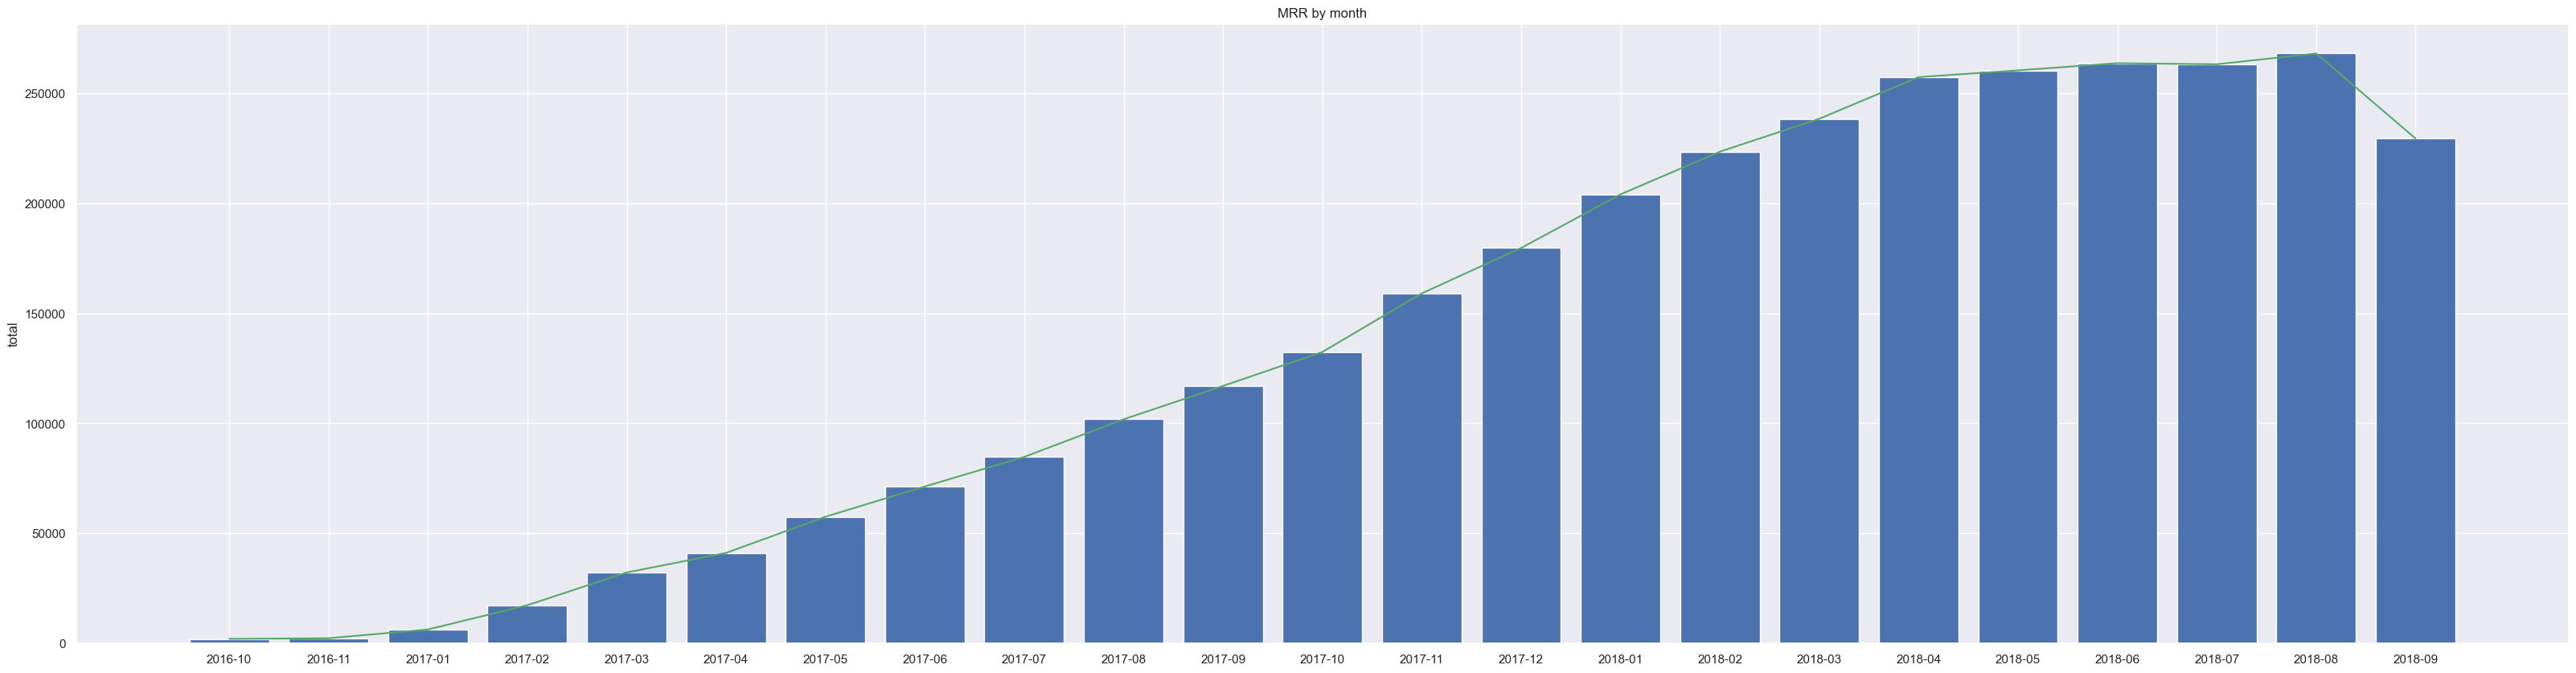

In [6]:
dates = date2mrr.keys()
y = date2mrr.values()

sns.set()
plt.figure(figsize=(40, 10))
plt.title("MRR by month")
plt.ylabel("total")
plt.bar(dates, y)
plt.plot(dates, y, c="g")
plt.show()

<div class="alert alert-info">
    
Давайте сделаем небольшую и наглядную проверку расчета **MMR**. 
    
Возьмём одного клиента `customer_id` = 084a0e74918bd829d509441c2504135e

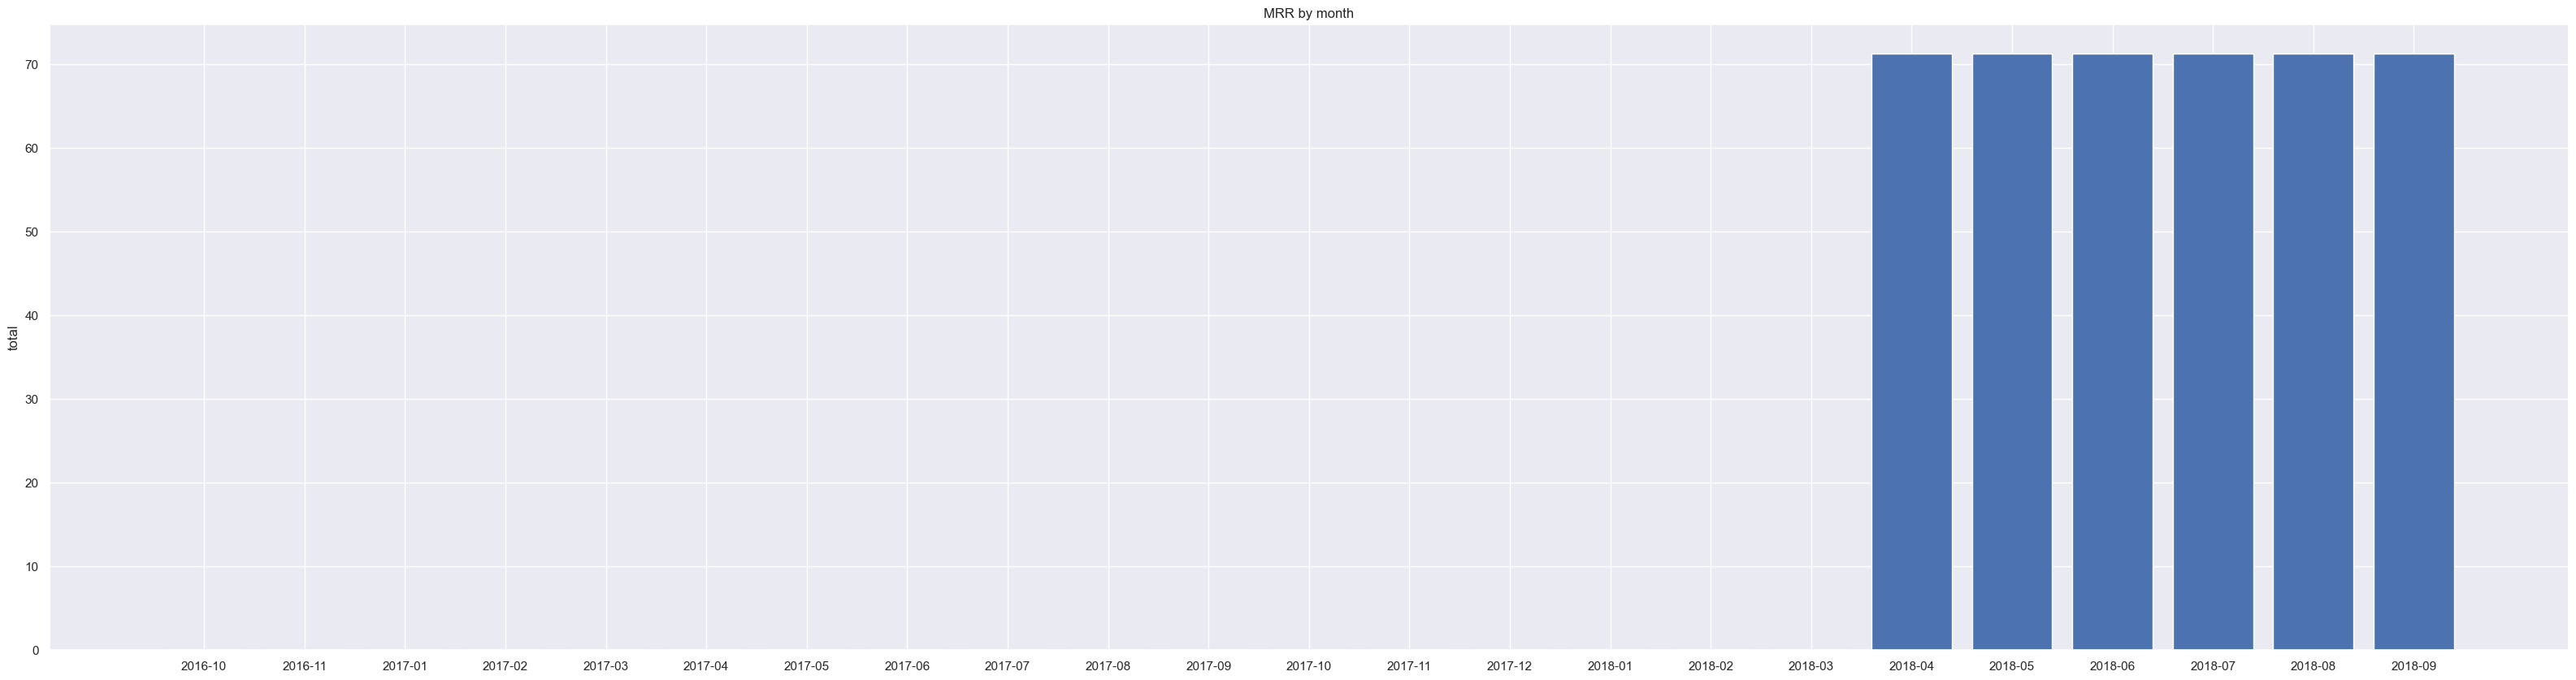

In [7]:
test_df = df_mrr[df_mrr.customer_id == "084a0e74918bd829d509441c2504135e"]

date2mrr = {}
for mdate in periods:
    my_df = test_df[
        (test_df["EndDate"].dt.to_period("M") > mdate) & (test_df["first_order"].dt.to_period("M") <= mdate)]
    mmrr = my_df["Amount_per_month"].sum()
    date2mrr[mdate] = mmrr

dates = date2mrr.keys()
y = date2mrr.values()

sns.set()
plt.figure(figsize=(40, 10))
plt.title("MRR by month")
plt.ylabel("total")
plt.bar(dates, y)
plt.show()

<div class="alert alert-success">
    
Как мы видим весь доход от клиента равномерно размазался по месяцам.

# Отток клиентов - Churn rate

In [8]:
df_mrr["end_month"] = df_mrr["EndDate"].dt.to_period("M")
df_mrr["start_month"] = df_mrr["first_order"].dt.to_period("M")

grouped_start = df_mrr.groupby("start_month", as_index=False).agg(
    start_customer_id_count=("customer_id", "count")
)
grouped_end = df_mrr.groupby("end_month", as_index=False).agg(
    end_customer_id_count=("customer_id", "count")
)

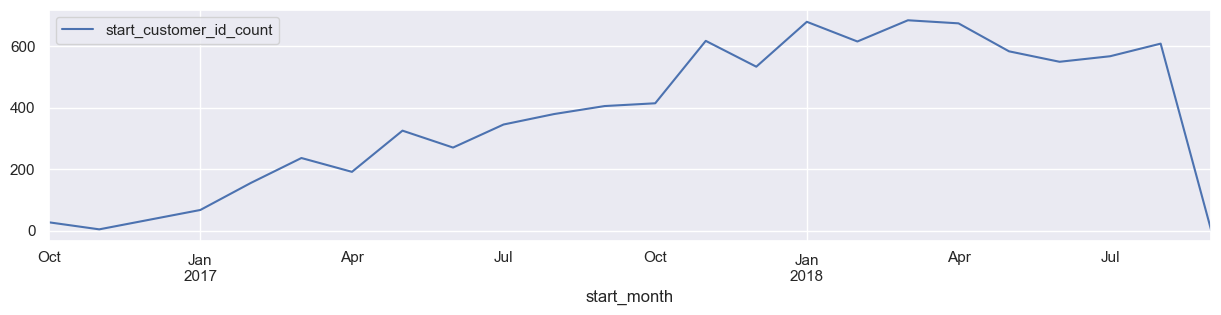

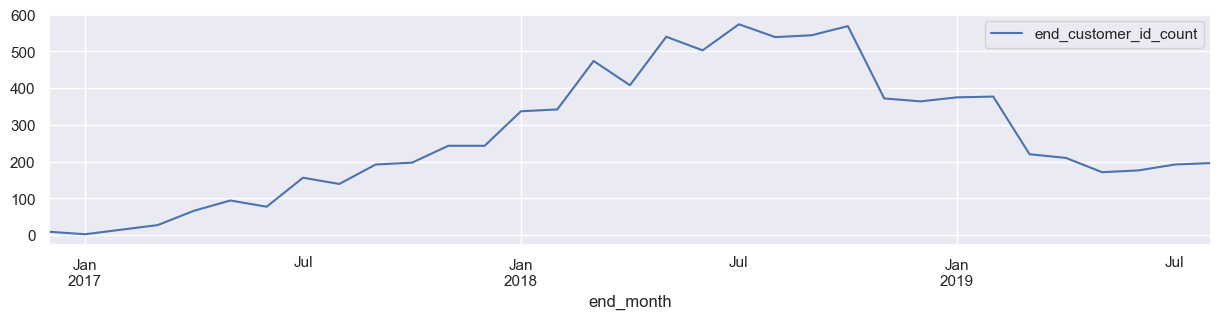

In [9]:
grouped_start.plot(x="start_month", figsize=(15, 3));
grouped_end.plot(x="end_month", figsize=(15, 3));

# Но что насчет оттока клиентов?

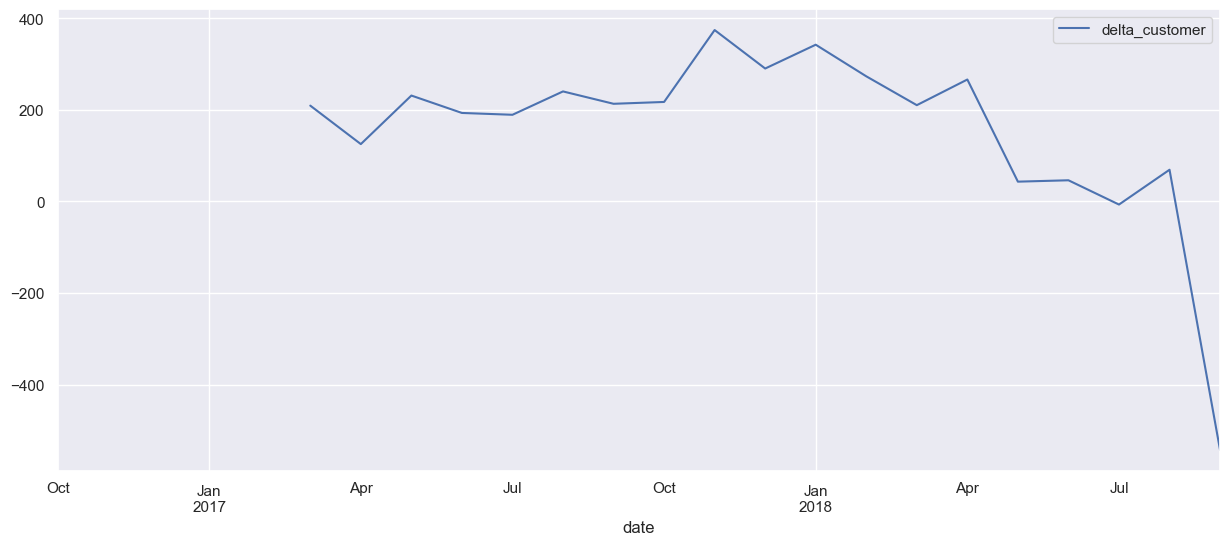

In [10]:
grouped_end["date"] = grouped_end["end_month"]
grouped_start["date"] = grouped_start["start_month"]
grouped_start = grouped_start.merge(grouped_end, how="left", on="date")
grouped_start["delta_customer"] = (
        grouped_start["start_customer_id_count"] - grouped_start["end_customer_id_count"]
)

grouped_start[["date", "delta_customer"]].plot(x="date", figsize=(15, 6));

<div class="alert alert-warning">
    
Как мы заметили ранее доход от клиентов равномерно росс по месяцам.

Видно, что хоть первая метрика MRR и говорит, что у на ростущий тренд прибыли, другая метрика CR говорит, что мы теряем клиентов быстрее, чем приходят новые

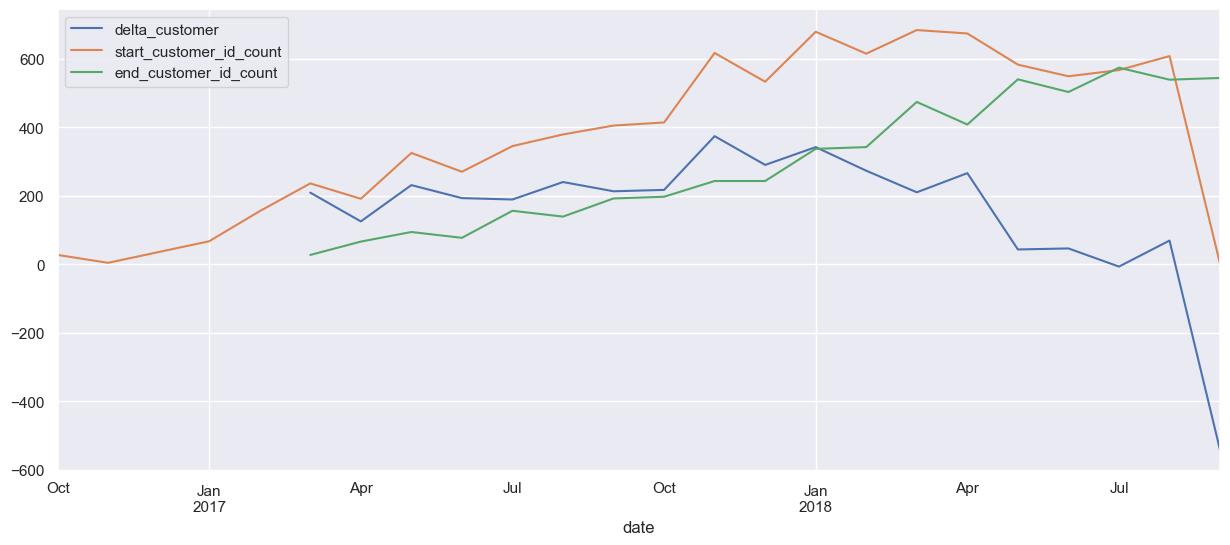

In [11]:
grouped_start[["date", "delta_customer", 'start_customer_id_count', 'end_customer_id_count']].plot(x="date",
                                                                                                   figsize=(15, 6));

# Итоги и выводы


* Разобрали, как использовать python для подсчете метрик
* Смотрите лучше сразу на несколько метрик сразу
* Используйте всю мощь python, чтобы анализировать ваши данные 💪💪💪💪
